# Необходимые библиотеки

In [1]:
#!pip install sentence_transformers
#!pip install fasttext
#!pip install pymorphy2
# !pip install xgboost
# !pip install imblearn
# !pip install textattack
# !pip install transformers
# !pip install catboost

In [2]:
from datasets import load_dataset

from sentence_transformers import SentenceTransformer
from transformers import pipeline

# import textattack
# from textattack.augmentation import WordNetAugmenter

# import fasttext
# import fasttext.util

# import re
# import pymorphy2

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

/opt/homebrew/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /opt/homebrew/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /opt/homebrew/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


# Обработка данных

## Просто загрузка всех датасетов

In [3]:
dataset_train = load_dataset("cohere/miracl-ru-queries-22-12", split="train")
dataset_dev = load_dataset("cohere/miracl-ru-queries-22-12", split="dev")

In [4]:
df_train = dataset_train.to_pandas()
df_test = dataset_dev.to_pandas()

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4683 entries, 0 to 4682
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query_id           4683 non-null   object
 1   query              4683 non-null   object
 2   positive_passages  4683 non-null   object
 3   negative_passages  4683 non-null   object
 4   emb                4683 non-null   object
dtypes: object(5)
memory usage: 183.1+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query_id           1252 non-null   object
 1   query              1252 non-null   object
 2   positive_passages  1252 non-null   object
 3   negative_passages  1252 non-null   object
 4   emb                1252 non-null   object
dtypes: object(5)
memory usage: 49.0+ KB


In [7]:
df_testA = load_dataset("cohere/miracl-ru-queries-22-12", split="testA").to_pandas()
df_testB = load_dataset("cohere/miracl-ru-queries-22-12", split="testB").to_pandas()

In [8]:
df_testA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query_id           911 non-null    object
 1   query              911 non-null    object
 2   positive_passages  911 non-null    object
 3   negative_passages  911 non-null    object
 4   emb                911 non-null    object
dtypes: object(5)
memory usage: 35.7+ KB


In [9]:
df_testB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query_id           718 non-null    object
 1   query              718 non-null    object
 2   positive_passages  718 non-null    object
 3   negative_passages  718 non-null    object
 4   emb                718 non-null    object
dtypes: object(5)
memory usage: 28.2+ KB


Количество сэмплов сходится с заявленным на странице датасета
(на последний номер строки данных на сайте смотреть, видимо, не стоит, объектов 4.68k, 1.25k, 911, 718)

In [10]:
# df_train.drop(columns=['emb', 'query_id'], axis = 0, inplace=True)
# df_test.drop(columns=['emb', 'query_id'], axis = 0, inplace=True)

## Предобработка текста

In [11]:
df_train.head()

,query_id,query,positive_passages,negative_passages,emb
0,1,Когда был спущен на воду первый миноносец «Спо...,"[{'docid': '2183682#1', 'text': 'Зачислен в сп...","[{'docid': '770018#0', 'text': 'Стерегу́щий — ...","[0.46318358, 0.053662203, -0.4220398, 0.277551..."
1,4,Как долго существовало британское телевизионно...,"[{'docid': '1534585#0', 'text': 'Хрустальный л...","[{'docid': '1534585#40', 'text': 'Хрустальный ...","[0.31484476, -0.104439735, 0.051660538, 0.5222..."
2,6,Когда родилась Князева Марина Леонидовна?,"[{'docid': '4811421#0', 'text': 'Князева Марин...","[{'docid': '4811421#6', 'text': 'Окончила факу...","[0.02799829, 0.28310648, 0.16567738, 0.2396494..."
3,11,Кто был главным художником мира Зен?,"[{'docid': '182190#24', 'text': 'В книге ""Half...","[{'docid': '6406533#10', 'text': 'Эверетт Шинн...","[0.6196511, 0.2840687, 0.058455035, 0.06318734..."
4,12,Как звали предполагаемого убийцу Джона Кеннеди?,"[{'docid': '794011#29', 'text': 'В 1966 году о...","[{'docid': '1871#71', 'text': 'Официальные дан...","[0.36751303, 0.15708618, 0.19431534, 0.0411750..."


## Аугментация

### Лемматизация queries

In [12]:
# Инициализация лемматизатора
# morph = pymorphy2.MorphAnalyzer()

# # Функция для очистки и лемматизации текста
# def clean_and_lemmatize(text):
#     # Удаление спецсимволов, кроме букв и пробелов
#     text = re.sub(r'[^а-яА-Я\s]', '', text)
#     # Лемматизация
#     words = text.split()
#     lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
#     return ' '.join(lemmatized_words)

In [13]:
# df_train['query'] = df_train['query'].apply(clean_and_lemmatize)
# df_test['query'] = df_test['query'].apply(clean_and_lemmatize)

In [14]:
# df_train.drop(columns = 'query_id', inplace = True)
# df_test.drop(columns = 'query_id', inplace = True)

In [15]:
# df_train.head()

### Кодировка queries в embeddings

In [16]:
# # Загрузка предобученной модели
# model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [17]:
# query_embeddings_train = model.encode(df_train['query'].tolist())
# query_embeddings_test = model.encode(df_test['query'].tolist())

In [18]:
# np.save("query_embeddings_train_SBERT_without_lemma.npy", query_embeddings_train)
# np.save("query_embeddings_test_SBERT_without_lemma.npy", query_embeddings_test)

In [19]:
query_embeddings_train = np.load("query_embeddings_train_SBERT_without_lemma.npy").tolist()
query_embeddings_test = np.load("query_embeddings_test_SBERT_without_lemma.npy").tolist()

In [20]:
df_train['query_emb'] = list(query_embeddings_train)
df_test['query_emb'] = list(query_embeddings_test)

In [21]:
df_train.head()

,query_id,query,positive_passages,negative_passages,emb,query_emb
0,1,Когда был спущен на воду первый миноносец «Спо...,"[{'docid': '2183682#1', 'text': 'Зачислен в сп...","[{'docid': '770018#0', 'text': 'Стерегу́щий — ...","[0.46318358, 0.053662203, -0.4220398, 0.277551...","[-0.11629089713096619, 0.363239586353302, -0.0..."
1,4,Как долго существовало британское телевизионно...,"[{'docid': '1534585#0', 'text': 'Хрустальный л...","[{'docid': '1534585#40', 'text': 'Хрустальный ...","[0.31484476, -0.104439735, 0.051660538, 0.5222...","[0.2629813253879547, -0.2086327075958252, 0.07..."
2,6,Когда родилась Князева Марина Леонидовна?,"[{'docid': '4811421#0', 'text': 'Князева Марин...","[{'docid': '4811421#6', 'text': 'Окончила факу...","[0.02799829, 0.28310648, 0.16567738, 0.2396494...","[0.10427717864513397, 0.29542869329452515, -0...."
3,11,Кто был главным художником мира Зен?,"[{'docid': '182190#24', 'text': 'В книге ""Half...","[{'docid': '6406533#10', 'text': 'Эверетт Шинн...","[0.6196511, 0.2840687, 0.058455035, 0.06318734...","[-0.11577147990465164, 0.3673804700374603, -0...."
4,12,Как звали предполагаемого убийцу Джона Кеннеди?,"[{'docid': '794011#29', 'text': 'В 1966 году о...","[{'docid': '1871#71', 'text': 'Официальные дан...","[0.36751303, 0.15708618, 0.19431534, 0.0411750...","[-0.053212523460388184, 0.29044201970100403, -..."


In [22]:
df_test.head()

,query_id,query,positive_passages,negative_passages,emb,query_emb
0,0,Когда начался Кари́бский кризис?,"[{'docid': '105156#0', 'text': 'Кари́бский кри...","[{'docid': '105156#4', 'text': 'Первоначально,...","[0.044620123, -0.035441313, -0.04824933, 0.212...","[-0.07207422703504562, 0.006041878368705511, -..."
1,2,Как называлась Симбирская губерния с 1924?,"[{'docid': '82404#0', 'text': 'Симби́рская губ...","[{'docid': '3413393#0', 'text': 'Симбирский уе...","[0.38154602, 0.027124405, -0.53108597, 0.23427...","[0.041658878326416016, 0.11239001154899597, -0..."
2,3,Какое расстояние от Коло́мны до Москвы?,"[{'docid': '14080#1', 'text': 'Коломна находит...","[{'docid': '84#15', 'text': 'Кратчайшее рассто...","[0.046361923, 0.06825427, -0.3365682, 0.325307...","[0.4640441834926605, -8.022678957786411e-05, -..."
3,5,Когда был придуман пряник?,"[{'docid': '311359#5', 'text': 'Первые пряники...","[{'docid': '94341#20', 'text': 'Изобретение в ...","[0.15240201, 0.3902477, -0.042868875, 0.302212...","[-0.27133890986442566, 0.17585453391075134, -0..."
4,9,Можно излечиться от наркотической зависимости ...,"[{'docid': '3693182#23', 'text': 'Это, однако,...","[{'docid': '4279225#5', 'text': 'Поскольку эфф...","[0.06723844, -0.105674155, 0.12721957, 0.30928...","[0.07318349927663803, -0.12397386133670807, 0...."


## Преобразуем данные в нормальный вид

In [23]:
# Функция для создания строк с query, passage и label
def create_rows_from_passages(row):
    new_rows = []
    query = row['query_emb']

    # Обработка positive_passages
    for pos_passage in row['positive_passages']:
        new_rows.append({
            'query_emb': query,
            'query_id': row['query_id'],
            'passage_text': pos_passage['text'],  # Исправленный ключ
            'label': 1
        })
        

    # Обработка negative_passages
    for neg_passage in row['negative_passages']:
        new_rows.append({
            'query_emb': query,
            'query_id': row['query_id'],
            'passage_text': neg_passage['text'],
            'label': 0
        })

    return new_rows

In [24]:
# Применение функции ко всему DataFrame
new_rows = []
for index, row in df_train.iterrows():
    new_rows.extend(create_rows_from_passages(row))

# Создание нового DataFrame
df_train = pd.DataFrame(new_rows)

# Применение функции ко всему DataFrame
new_rows = []
for index, row in df_test.iterrows():
    new_rows.extend(create_rows_from_passages(row))

# Создание нового DataFrame
df_test = pd.DataFrame(new_rows)

In [25]:
df_train.head()

,query_emb,query_id,passage_text,label
0,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1
1,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,Стерегу́щий — русский миноносец типа «Сокол». ...,0
2,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,Эскадренный миноносец заложен в 1900 году на Н...,0
3,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,10 октября 1937 года эсминец был спущен на вод...,0
4,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,В 1901 году миноносец «Бодрый» был зачислен в ...,0


In [26]:
df_test.head()

,query_emb,query_id,passage_text,label
0,"[-0.07207422703504562, 0.006041878368705511, -...",0,"Кари́бский кризис — исторический термин, опред...",1
1,"[-0.07207422703504562, 0.006041878368705511, -...",0,"Политическое, дипломатическое и военное против...",1
2,"[-0.07207422703504562, 0.006041878368705511, -...",0,В октябре 1962 года произошел Карибский кризис...,1
3,"[-0.07207422703504562, 0.006041878368705511, -...",0,"Первоначально, после победы революции на Кубе ...",0
4,"[-0.07207422703504562, 0.006041878368705511, -...",0,"Невозможно однозначно утверждать, стало ли уда...",0


### Лемматизация пассажей

In [27]:
# df_train['passage_text'] = df_train['passage_text'].apply(clean_and_lemmatize)
# df_test['passage_text'] = df_test['passage_text'].apply(clean_and_lemmatize)

### Кодировка passages

In [28]:
# # Кодирование пассажей
# passage_embeddings_train = model.encode(df_train['passage_text'].tolist())
# passage_embeddings_test = model.encode(df_test['passage_text'].tolist())

In [29]:
# np.save("passage_embeddings_train_SBERT_without_lemma.npy", passage_embeddings_train)
# np.save("passage_embeddings_test_SBERT_without_lemma.npy", passage_embeddings_test)

In [30]:
passage_embeddings_train = np.load("passage_embeddings_train_SBERT_without_lemma.npy").tolist()
passage_embeddings_test =  np.load("passage_embeddings_test_SBERT_without_lemma.npy").tolist()

In [31]:
df_train['passage_emb'] = list(passage_embeddings_train)
df_test['passage_emb'] = list(passage_embeddings_test)

In [32]:
df_train.drop(columns = 'passage_text', inplace = True)
df_test.drop(columns = 'passage_text', inplace = True)

## Другие варианты кодировки

In [33]:
# # Загрузка модели FastText
# fasttext.util.download_model('ru', if_exists='ignore') 
# model = fasttext.load_model('cc.ru.300.bin')

In [34]:
# # кодировка пассажей
# passage_embeddings_train =[model.get_sentence_vector(passage) for passage in df_train['passage_text'].tolist()]
# passage_embeddings_test = [model.get_sentence_vector(passage) for passage in df_test['passage_text'].tolist()]

# query_embeddings_train = [model.get_sentence_vector(passage) for passage in df_train['query_text'].tolist()]
# query_embeddings_test = [model.get_sentence_vector(passage) for passage in df_test['query_text'].tolist()]

In [35]:
# # Сохраняем эмбеддинги в файлы
# np.save("passage_embeddings_train_FAST.npy", passage_embeddings_train)
# np.save("passage_embeddings_test_FAST.npy", passage_embeddings_test)
# np.save("query_embeddings_train_FAST.npy", query_embeddings_train)
# np.save("query_embeddings_test_FAST.npy", query_embeddings_test)

## Финальный вид датасетов

In [36]:
df_train.head()

,query_emb,query_id,label,passage_emb
0,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,1,"[-0.2847347855567932, 0.24554172158241272, -0...."
1,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.19520770013332367, 0.1378668248653412, -0...."
2,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.1887834370136261, 0.15527963638305664, -0...."
3,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.21765783429145813, 0.21826159954071045, -0..."
4,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.12288299947977066, 0.05616552382707596, -0..."


In [37]:
df_test.head()

,query_emb,query_id,label,passage_emb
0,"[-0.07207422703504562, 0.006041878368705511, -...",0,1,"[-0.2523987889289856, -0.17523470520973206, -0..."
1,"[-0.07207422703504562, 0.006041878368705511, -...",0,1,"[-0.2871626019477844, 0.16858047246932983, -0...."
2,"[-0.07207422703504562, 0.006041878368705511, -...",0,1,"[-0.17040406167507172, 0.11704376339912415, -0..."
3,"[-0.07207422703504562, 0.006041878368705511, -...",0,0,"[-0.347606360912323, 0.20325510203838348, -0.2..."
4,"[-0.07207422703504562, 0.006041878368705511, -...",0,0,"[-0.35743096470832825, 0.17954352498054504, -0..."


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33921 entries, 0 to 33920
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query_emb    33921 non-null  object
 1   query_id     33921 non-null  object
 2   label        33921 non-null  int64 
 3   passage_emb  33921 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query_emb    13100 non-null  object
 1   query_id     13100 non-null  object
 2   label        13100 non-null  int64 
 3   passage_emb  13100 non-null  object
dtypes: int64(1), object(3)
memory usage: 409.5+ KB


# Обучение модели

## Обучение различных моделей

**Линейная регрессия**

In [106]:
# Объединяем query_emb и passage_embeddings в один массив фичей
X_train = np.hstack((np.stack(df_train['query_emb'].values), np.stack(df_train['passage_emb'].values)))
y_train = df_train['label'].values

# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

X_test = np.hstack((np.stack(df_test['query_emb'].values), np.stack(df_test['passage_emb'].values)))
y_test = df_test['label'].values

In [ ]:
def train_show(model):
    # Обучение
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Оценка качества модели
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    ap = average_precision_score(y_test, y_pred)
    print(f"Average Precision: {ap:.4f}")

In [107]:
model = LogisticRegression(class_weight='balanced', max_iter=10000)
train_show(model)

Accuracy: 0.6185
Average Precision: 0.3319


**Дерево с дополнительными фичами**

In [41]:
import numpy as np
from scipy.spatial import distance

# Функция для расчета различных мер близости
def calculate_similarity_measures(query_emb, passage_emb):
    # Косинусная близость
    cosine_sim = 1 - distance.cosine(query_emb, passage_emb)
    
    # Евклидово расстояние
    euclidean_dist = distance.euclidean(query_emb, passage_emb)
    
    # Манхэттенское расстояние
    manhattan_dist = distance.cityblock(query_emb, passage_emb)
    
    # Дот-продукт
    dot_product = np.dot(query_emb, passage_emb)
    
    # Чебышёвское расстояние
    chebyshev_dist = distance.chebyshev(query_emb, passage_emb)
    
    return {
        'cosine_sim': cosine_sim,
        'euclidean_dist': euclidean_dist,
        'manhattan_dist': manhattan_dist,
        'dot_product': dot_product,
        'chebyshev_dist': chebyshev_dist
    }

# Применяем к каждому объекту в наборе данных
df_train['similarity_measures'] = df_train.apply(
    lambda row: calculate_similarity_measures(row['query_emb'], row['passage_emb']), axis=1
)

# Разворачиваем словарь с метриками в отдельные столбцы
train_tree = pd.concat([df_train, df_train['similarity_measures'].apply(pd.Series)], axis=1)

# Убираем вспомогательный столбец
df_train = df_train.drop(columns=['similarity_measures'])
train_tree = train_tree.drop(columns=['similarity_measures'])

# Применяем меры близости к каждому объекту в тестовом наборе данных
df_test['similarity_measures'] = df_test.apply(
    lambda row: calculate_similarity_measures(row['query_emb'], row['passage_emb']), axis=1
)

# Разворачиваем словарь с метриками в отдельные столбцы
test_tree = pd.concat([df_test, df_test['similarity_measures'].apply(pd.Series)], axis=1)

# Убираем вспомогательный столбец
df_test = df_test.drop(columns=['similarity_measures'])
test_tree = test_tree.drop(columns=['similarity_measures'])


# Теперь X_train будет включать новые признаки
X_train = np.hstack((
    np.stack(train_tree['query_emb'].values), 
    np.stack(train_tree['passage_emb'].values),
    train_tree[['cosine_sim', 'euclidean_dist', 'manhattan_dist', 'dot_product', 'chebyshev_dist']].values
))

y_train = df_train['label'].values

# Формируем X_test, добавляя новые признаки
X_test = np.hstack((
    np.stack(test_tree['query_emb'].values), 
    np.stack(test_tree['passage_emb'].values),
    test_tree[['cosine_sim', 'euclidean_dist', 'manhattan_dist', 'dot_product', 'chebyshev_dist']].values
))

y_test = df_test['label'].values


In [42]:
from sklearn.ensemble import RandomForestRegressor

def train_show(model):
    # Обучение
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Оценка качества модели
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    ap = average_precision_score(y_test, y_pred)
    print(f"Average Precision: {ap:.4f}")

    
# Инициализация модели случайного леса
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

train_show(rf_model)

**CatBoost**

In [40]:
df_train.head()

,query_emb,query_id,label,passage_emb
0,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,1,"[-0.2847347855567932, 0.24554172158241272, -0...."
1,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.19520770013332367, 0.1378668248653412, -0...."
2,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.1887834370136261, 0.15527963638305664, -0...."
3,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.21765783429145813, 0.21826159954071045, -0..."
4,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.12288299947977066, 0.05616552382707596, -0..."


In [51]:
import catboost as cb

# Объединение query_emb и passage_emb в один массив признаков
X_train = np.hstack((np.stack(df_train['query_emb'].values), np.stack(df_train['passage_emb'].values)))
y_train = df_train['label'].values


X_test = np.hstack((np.stack(df_test['query_emb'].values), np.stack(df_test['passage_emb'].values)))
y_test = df_test['label'].values

# Используем query_id как group_id
group_train = df_train['query_id'].values
group_test = df_test['query_id'].values

In [52]:
# Создаем Pool для данных с указанием групп
train_pool = cb.Pool(data=X_train, label=y_train, group_id=group_train)

In [43]:
# Инициализация и обучение CatBoostRanker
catboost_ranker = cb.CatBoostRanker(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    verbose=100
)

# Обучение модели
catboost_ranker.fit(train_pool)


0:	total: 225ms	remaining: 3m 44s
100:	total: 8.4s	remaining: 1m 14s
200:	total: 16.8s	remaining: 1m 6s
300:	total: 24.3s	remaining: 56.5s
400:	total: 32.2s	remaining: 48.1s
500:	total: 41.6s	remaining: 41.5s
600:	total: 49.8s	remaining: 33.1s
700:	total: 57.8s	remaining: 24.7s
800:	total: 1m 6s	remaining: 16.6s
900:	total: 1m 14s	remaining: 8.2s
999:	total: 1m 22s	remaining: 0us


In [53]:
test_pool = cb.Pool(data=X_test, group_id=group_test)
y_pred = catboost_ranker.predict(test_pool)

In [54]:
# # Оценка качества модели
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

ap = average_precision_score(y_test, y_pred)
print(f"Average Precision: {ap:.4f}")

Average Precision: 0.4089


In [55]:
import numpy as np

# Функция для вычисления DCG
def dcg_score(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(1, len(y_true) + 1) + 1)
    return np.sum(gains / discounts)

# Функция для вычисления nDCG
def ndcg_score(y_true, y_pred, k=10):
    best_dcg = dcg_score(y_true, y_true, k)  # идеальное DCG
    actual_dcg = dcg_score(y_true, y_pred, k)
    return actual_dcg / best_dcg if best_dcg > 0 else 0

# Пример применения
y_true = df_test['label'].values  # истинные метки

# Расчет nDCG@10
ndcg_value = ndcg_score(y_true, y_pred, k=10)
print(f"nDCG@10: {ndcg_value:.4f}")

nDCG@10: 0.8643


In [56]:
# Функция для вычисления Recall
def recall_at_k(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = np.sum(y_true)
    return relevant / np.sum(y_true)

# Пример применения Recall
recall_value = recall_at_k(y_true, y_pred, k=10)
print(f"Recall@10: {recall_value:.4f}")

Recall@10: 1.0000


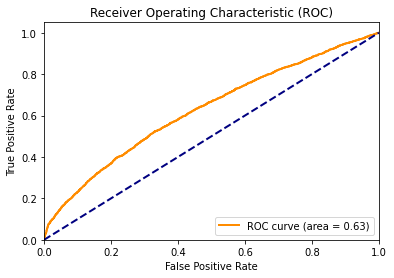

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Предсказания от модели CatBoost (скоры)
y_scores = catboost_ranker.predict(test_pool)

# Истинные метки классов
y_true = df_test['label'].values

# Рассчитываем значения для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Вычисляем AUC (площадь под ROC-кривой)
roc_auc = auc(fpr, tpr)

# Построение графика ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()